# In this notebook, the ARIMA and SARIMA models will be explored

The methodology followed for producing an ARIMA model is summarized in the following flowchart, taken from Hyndmann.

![Hyndmann Modeling Porcess](hyndman-modeling-process.png)

In [1]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get the data
df_CHN_CTC_leaf = pd.read_csv('../Data/df_CHN_CTC_leaf.csv')
# print(df_CHN_CTC_leaf.tail(40))
# grab 2020 data separately
df_CHN_CTC_leaf_2020 = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf['week_ending']) > pd.to_datetime('2020-01-01')]
df_CHN_CTC_leaf = df_CHN_CTC_leaf[pd.to_datetime(df_CHN_CTC_leaf['week_ending']) < pd.to_datetime('2020-01-01')]

price_series = df_CHN_CTC_leaf['ctc_leaf_avg_price']
time_series = pd.to_datetime(df_CHN_CTC_leaf['week_ending'])
price_series.index = time_series

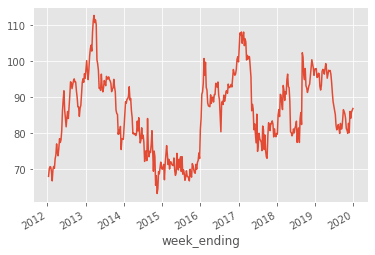

In [5]:
price_series.plot();

In [6]:
def plot_series_and_difference(axs, price_series, time_series, title):
    diff = price_series.diff()
    axs[0].plot(time_series, price_series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(time_series, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

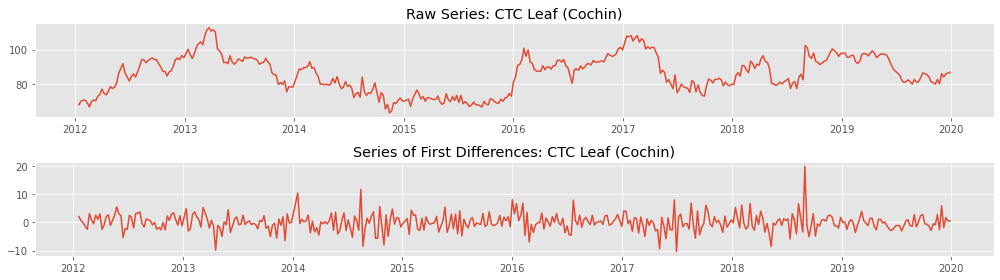

In [7]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, price_series, time_series, 'CTC Leaf (Cochin)')
fig.tight_layout()

In [8]:
# Check for stationarity
price_differences = price_series.diff()[1:]
ADF_p_value = sm.tsa.stattools.adfuller(price_differences)
print("ADF p-value for differenced price series: {0:2.2f}".format(ADF_p_value[1]))

ADF p-value for differenced price series: 0.00


So the differenced series is stationary, and we can attempt to model it as an ARMA process.

We need to determine the correct order for the AR and MA models, so let's look at the auto and partial auto correlation plots.

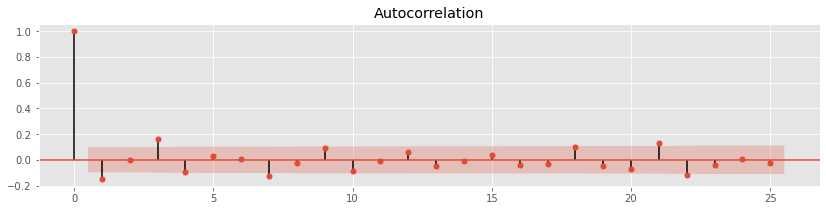

In [9]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_differences, lags=25, ax=ax)

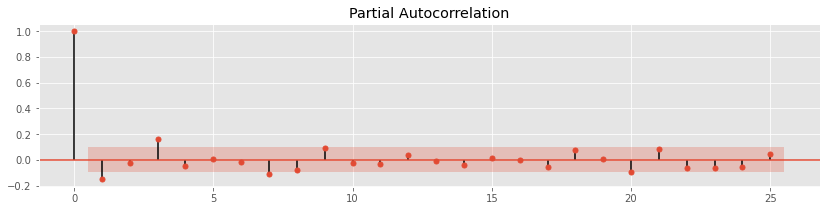

In [10]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_pacf(price_differences, lags=25, ax=ax)

We see the following evidence:
  - Oscillatory behavior in the autocorrelation plot. One significant data point at the beginning of the plot. So ?????
  - One significant partial autocorrelations at the beginning of the plot.
  
This suggests that the differenced series may be well modeled as an $AR(1)$ series.

Since we applied *one* difference to achieve stationarity, this suggests that we should model the *original* series as an $ARIMA(1, 1, !)$.

In [11]:
# # try 2nd rder differencing
# # Check for stationarity
# price_second_differences = price_differences.diff()[1:]
# ADF_p_value = sm.tsa.stattools.adfuller(price_second_differences)
# print("ADF p-value for differenced price series: {0:2.2f}".format(ADF_p_value[1]))

In [12]:
# fig, ax = plt.subplots(1, figsize=(14, 3))
# _ = sm.graphics.tsa.plot_acf(price_second_differences, lags=25, ax=ax)
# fig, ax = plt.subplots(1, figsize=(14, 3))
# _ = sm.graphics.tsa.plot_pacf(price_second_differences, lags=25, ax=ax)

## Fit the ARIMA model

In [13]:
price_model = ARIMA(price_series, order=(1, 1, 1)).fit()

In [14]:
def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]

In [15]:
print("ARIMA(1, 1, 0) coefficients from Price model:\n  Intercept {0:2.2f}\n  AR {1}".format(
    price_model.params[0], 
        format_list_of_floats(list(price_model.params[1:]))
    ))

ARIMA(1, 1, 0) coefficients from Price model:
  Intercept 0.05
  AR ['-0.10', '-0.05']


Let's simulate some data using these coefficients and see if it looks like our differenced data.

In [16]:
def auto_regressive_process(size, coefs, init=None):
    """Generate an autoregressive process with Gaussian white noise.  The
    implementation is taken from here:
    
      http://numpy-discussion.10968.n7.nabble.com/simulate-AR-td8236.html
      
    Exaclty how lfilter works here takes some pen and paper effort.
    """
    coefs = np.asarray(coefs)
    if init == None:
        init = np.array([0]*len(coefs))
    else:
        init = np.asarray(init)
    init = np.append(init, np.random.normal(size=(size - len(init))))
    assert(len(init) == size)
    a = np.append(np.array([1]), -coefs)
    b = np.array([1])
    return pd.Series(signal.lfilter(b, a, init))

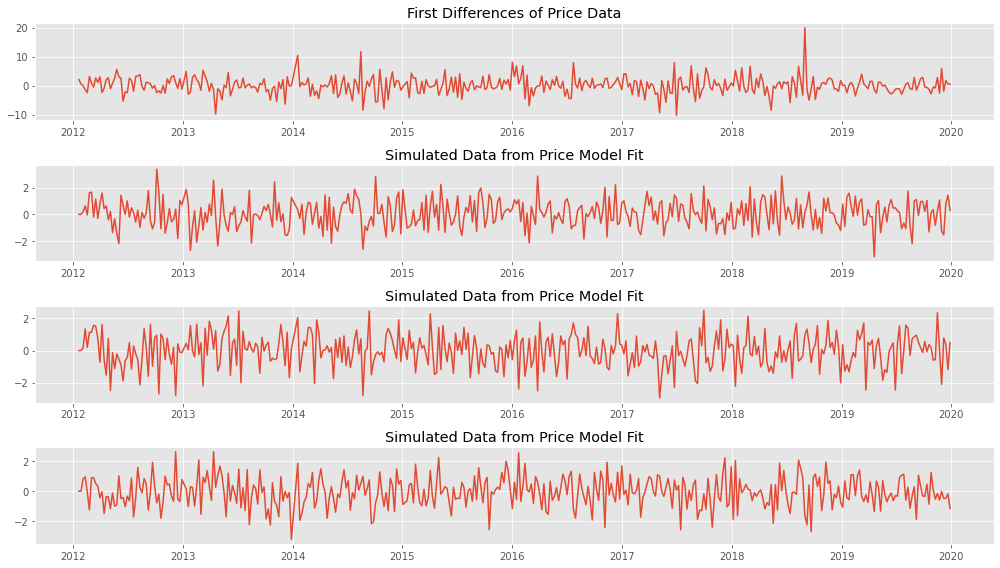

In [17]:
fig, ax = plt.subplots(4, figsize=(14, 8))

ax[0].plot(time_series[1:], price_differences)
ax[0].set_title("First Differences of Price Data")

for i in range(1, 4):
    simulated_data = auto_regressive_process(len(price_differences), 
                                             list(price_model.params)[1:])
    simulated_data.index = time_series[1:]
    ax[i].plot(simulated_data.index, simulated_data)
    ax[i].set_title("Simulated Data from Price Model Fit")
    
plt.tight_layout()

We have done a bit better than the naive forecast of predicting the last observed value.

We can also use the fit model to project prices into the future.

In [18]:
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARIMA Model Results                               
================================================================================
Dep. Variable:     D.ctc_leaf_avg_price   No. Observations:                  411
Model:                   ARIMA(1, 1, 1)   Log Likelihood               -1041.313
Method:                         css-mle   S.D. of innovations              3.048
Date:                  Thu, 17 Sep 2020   AIC                           2090.626
Time:                          19:29:26   BIC                           2106.700
Sample:                               1   HQIC                          2096.985
                                                                                
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0450      0.130      0.348      0.728      -0.209       0.299
ar.L1.D.ctc_leaf_avg_price    -0.1045      0.189     -0.554      0.580      -0.474       0.265
ma.L1.D.ctc_leaf_avg_price    -0.0489      0.185     -0.264      0.792      -0.412       0.314
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -9.5732           +0.0000j            9.5732            0.5000
MA.1           20.4700           +0.0000j           20.4700            0.0000
-----------------------------------------------------------------------------
"""

In [19]:
price_series[-100:]

week_ending
2018-02-03    90.83
2018-02-10    90.56
2018-02-17    88.16
2018-02-24    86.60
2018-03-03    93.30
              ...  
2019-11-30    86.08
2019-12-07    84.15
2019-12-14    85.86
2019-12-21    86.39
2019-12-28    86.89
Name: ctc_leaf_avg_price, Length: 100, dtype: float64

week_ending
2018-02-03    0.336249
2018-02-10    0.014608
2018-02-17    0.048206
2018-02-24    0.044696
2018-03-03    0.045063
                ...   
2019-11-30    0.045028
2019-12-07    0.045028
2019-12-14    0.045028
2019-12-21    0.045028
2019-12-28    0.045028
Length: 100, dtype: float64


Text(0.5, 1.0, 'Forecasts for Price')

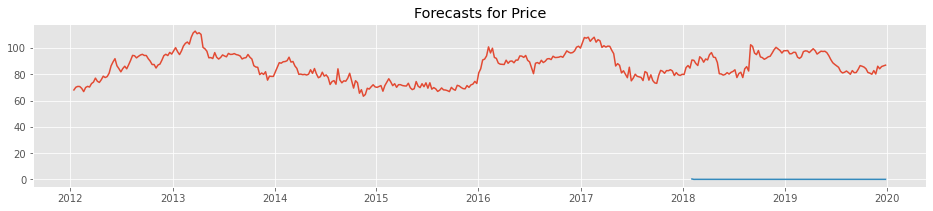

In [22]:
fig, ax = plt.subplots(1, figsize=(16, 3))
ax.plot(price_series.index, price_series)

# predictions = price_model.predict(
#    price_series.index.max(), pd.to_datetime('2020-09-12'), 
#    dynamic=True)

price_model = ARIMA(price_series, order=(1, 1, 1)).fit()

predictions = price_model.predict('2018-02-03', '2019-12-28', dynamic=True)
print(predictions)
ax.plot(predictions.index, predictions)
ax.set_title("Forecasts for Price")

If our model is good, the residuals should have no patterns whatsoever, i.e. be *white noise*

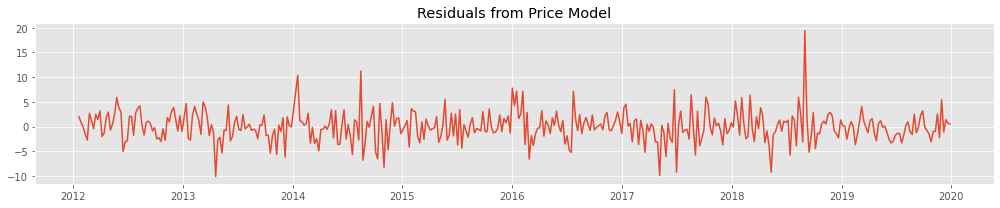

In [23]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_model.resid.index, price_model.resid)
ax.set_title("Residuals from Price Model")
plt.tight_layout()

One way to diagnose this is to check if any autocorrelation remains in the residuals.

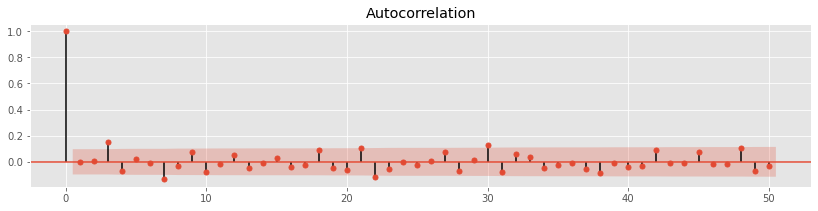

In [24]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_model.resid, lags=50, ax=ax)

### Model Selection: AIC

In [25]:
parameters = [
    {'AR': 2, 'MA': 0},
    {'AR': 2, 'MA': 1},
    {'AR': 1, 'MA': 0},
    {'AR': 1, 'MA': 1},
    {'AR': 3, 'MA': 0},
    {'AR': 3, 'MA': 1}
]

models = {}
for params in parameters:
    models[(params['AR'], params['MA'])] = ARIMA(price_series, order=(params['AR'], 1, params['MA'])).fit()
    
for model_params in models:
    print("ARIMA({}, 1, {}) AIC: {}".format(model_params[0], model_params[1], models[model_params].aic))

ARIMA(2, 1, 0) AIC: 2090.4780128400175
ARIMA(2, 1, 1) AIC: 2086.769481885754
ARIMA(1, 1, 0) AIC: 2088.6958921646
ARIMA(1, 1, 1) AIC: 2090.6257909046717
ARIMA(3, 1, 0) AIC: 2081.4707156798518
ARIMA(3, 1, 1) AIC: 2082.3967226022896


In [26]:
# Calculating MAPE (Mean Absolute Precentage Error)
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## Poor results! Try Auto ARIMA

In [27]:
! pip install pmdarima

In [28]:
from pmdarima.arima import auto_arima

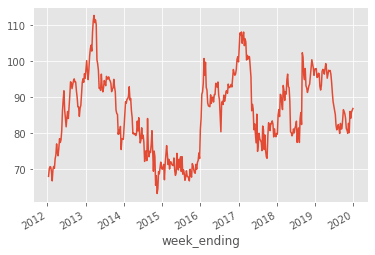

In [29]:
price_series.plot();

In [30]:
from pmdarima.arima import ADFTest

In [31]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(price_series)

(0.23022144267525393, True)

#### Data is non-stationary

In [32]:
# Train test split. Use some data to train, then test against remaing data to evaluate the model.

price_series_train = price_series[:350]
price_series_test = price_series[350:] 

In [33]:
print(f'train on {len(price_series_train)} data points')
print(f'test on {len(price_series_test)} data points')

train on 350 data points
test on 62 data points


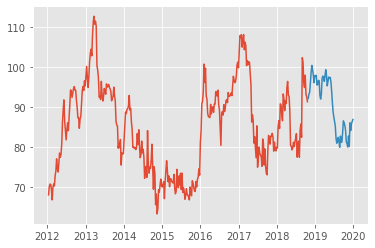

In [34]:
plt.plot(price_series_train)
plt.plot(price_series_test)

In [35]:
price_model = auto_arima(price_series_train, start_p=0, d=1, start_q=0, 
                         max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                         max_Q=5, m=52, seasonal=True,
                         error_action='warn', trace=True,
                         suppress_warnings=True, stepwise=True,
                         random_state=13, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1763.291, Time=0.30 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1652.838, Time=1.52 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=7.97 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1746.207, Time=0.23 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=1634.262, Time=5.14 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=20.35 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=5.01 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=inf, Time=3.53 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=1635.287, Time=7.54 sec
 ARIMA(1,1,1)(2,1,0)[52]             : AIC=1635.888, Time=7.71 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=1633.951, Time=5.76 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1652.380, Time=1.67 sec
 ARIMA(0,1,1)(2,1,1)[52]             : AIC=inf, Time=20.63 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=inf, Time=5.59 sec
 ARIMA(0,1,2)(2,1,0)[52]             : AIC=1635

In [36]:
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  350
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 52)   Log Likelihood                -812.976
Date:                             Thu, 17 Sep 2020   AIC                           1633.951
Time:                                     19:33:35   BIC                           1648.726
Sample:                                          0   HQIC                          1639.866
                                             - 350                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1770      0.063     -2.809      0.005      -0.301      -0.054
ar.S.L52      -0.7579      0.063    -11.990      0.000      -0.882      -0.634
ar.S.L104     -0.3316      0.076     -4.381      0.000      -0.480      -0.183
sigma2        12.5194      0.777     16.106      0.000      10.996      14.043
===================================================================================
Ljung-Box (Q):                       79.32   Jarque-Bera (JB):               139.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.59
Prob(H) (two-sided):                  0.18   Kurtosis:                         6.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Best model is SARIMAX (0,1,1)(2,1,0)[52] with a seasonality of 52 weeks AIC = 1633.951

In [37]:
predictions = pd.DataFrame(price_model.predict(n_periods=62),index=price_series_test.index)
predictions.columns = ['predicted_price']
predictions

,predicted_price
week_ending,
2018-10-27,90.639684
2018-11-03,91.833982
2018-11-10,92.845181
2018-11-17,93.445773
2018-11-24,92.489161
...,...
2019-11-30,96.358038
2019-12-07,98.042166
2019-12-14,98.631787


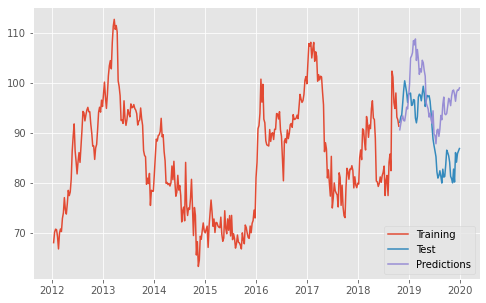

In [38]:
plt.figure(figsize=(8,5))
plt.plot(price_series_train, label='Training')
plt.plot(price_series_test, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend(loc='Left corner')
plt.show()

In [39]:
# Calculating MAPE (Mean Absolute Precentage Error), as advised by Dr. Agrawal
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [40]:
print(f'MAPE = {mape(price_series_test, predictions)}')

MAPE = 9.996468813897012


### MAPE = 9.996468813897012 (over 2020 predictions is not bad given COVID disruptions)

In [41]:
price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  350
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 52)   Log Likelihood                -812.976
Date:                             Thu, 17 Sep 2020   AIC                           1633.951
Time:                                     19:35:50   BIC                           1648.726
Sample:                                          0   HQIC                          1639.866
                                             - 350                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1770      0.063     -2.809      0.005      -0.301      -0.054
ar.S.L52      -0.7579      0.063    -11.990      0.000      -0.882      -0.634
ar.S.L104     -0.3316      0.076     -4.381      0.000      -0.480      -0.183
sigma2        12.5194      0.777     16.106      0.000      10.996      14.043
===================================================================================
Ljung-Box (Q):                       79.32   Jarque-Bera (JB):               139.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.59
Prob(H) (two-sided):                  0.18   Kurtosis:                         6.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### The model is doing much better


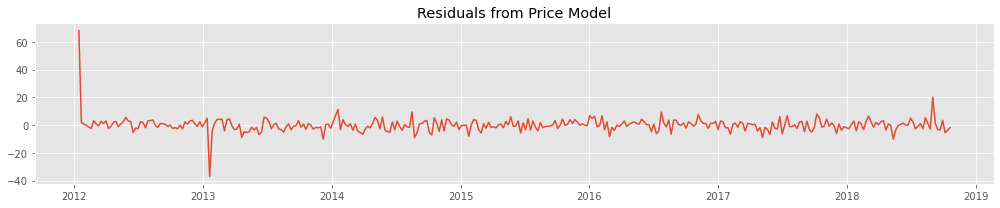

In [42]:
# Let's check the residuals to see if their variability looks like white noise

fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_series_train.index, price_model.resid())
ax.set_title("Residuals from Price Model")
plt.tight_layout()

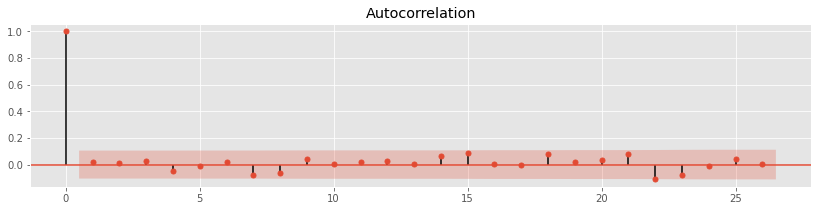

In [43]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(price_model.resid(), ax=ax)

### Looks good! There are no significant autocorrelations.

### Now that we found accetable results from the test data
##### Best model:  ARIMA(0,1,1)(2,1,0)[52] with test data (AIC = 1633.951)

### Now let's try with a seasonalty of 104 weeks because seasonality from year to year is not apparent)

In [44]:
# Let's try with different seasonality m=104
best_price_model = auto_arima(price_series, start_p=0, d=1, start_q=0, 
                              max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                              max_Q=5, m=104, seasonal=True,
                              error_action='warn', trace=True,
                              suppress_warnings=True, stepwise=True,
                              random_state=13, n_fits=50)
best_price_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[104]             : AIC=1757.918, Time=1.31 sec
 ARIMA(1,1,0)(1,1,0)[104]             : AIC=inf, Time=8.40 sec
 ARIMA(0,1,1)(0,1,1)[104]             : AIC=inf, Time=55.37 sec
 ARIMA(0,1,0)(1,1,0)[104]             : AIC=inf, Time=5.11 sec
 ARIMA(0,1,0)(0,1,1)[104]             : AIC=inf, Time=32.26 sec
 ARIMA(0,1,0)(1,1,1)[104]             : AIC=inf, Time=34.21 sec
 ARIMA(1,1,0)(0,1,0)[104]             : AIC=1747.678, Time=1.26 sec
 ARIMA(1,1,0)(0,1,1)[104]             : AIC=inf, Time=40.52 sec
 ARIMA(1,1,0)(1,1,1)[104]             : AIC=inf, Time=32.93 sec
 ARIMA(2,1,0)(0,1,0)[104]             : AIC=1748.834, Time=2.10 sec
 ARIMA(1,1,1)(0,1,0)[104]             : AIC=1749.298, Time=2.19 sec
 ARIMA(0,1,1)(0,1,0)[104]             : AIC=1747.459, Time=1.31 sec
 ARIMA(0,1,1)(1,1,0)[104]             : AIC=1682.986, Time=9.65 sec
 ARIMA(0,1,1)(2,1,0)[104]             : AIC=1675.042, Time=39.35 sec
 ARIMA(0,1,1)(2,1,1)[104]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  412
Model:             SARIMAX(2, 1, 2)x(2, 1, [], 104)   Log Likelihood                -824.393
Date:                              Thu, 17 Sep 2020   AIC                           1662.785
Time:                                      20:53:17   BIC                           1688.873
Sample:                                           0   HQIC                          1673.218
                                              - 412                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9685      0.033    -29.225      0.000      -1.033      -0.904
ar.L2         -0.9570      0.028    -34.720      0.000      -1.011      -0.903
ma.L1          0.8800      0.043     20.698      0.000       0.797       0.963
ma.L2          0.9250      0.035     26.481      0.000       0.857       0.993
ar.S.L104     -0.6590      0.089     -7.396      0.000      -0.834      -0.484
ar.S.L208     -0.2963      0.112     -2.654      0.008      -0.515      -0.078
sigma2        10.6461      0.867     12.277      0.000       8.947      12.346
===================================================================================
Ljung-Box (Q):                       19.25   Jarque-Bera (JB):               100.56
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.56
Prob(H) (two-sided):                  0.19   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### And again check the residuals to see if their variability looks like white noise

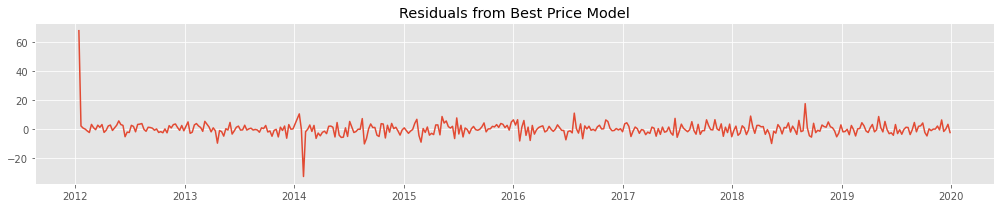

In [46]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(price_series.index, best_price_model.resid())
ax.set_title("Residuals from Best Price Model")
plt.tight_layout()

### and check for correlations

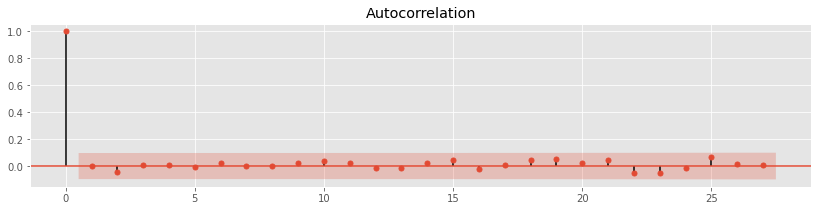

In [47]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(best_price_model.resid(), ax=ax)

### The best model is still ARIMAX(0,1,1)(2,1,0)[52] with test data (AIC = 1633.951)

#### Which is better than SARIMAX (2,1,2)(2,1,0)[104]  with all data upto 2019 (AIC = 1662.785)

#### Try again with data upto the end of 2019, and a seasonality of 3 years

In [53]:
# Let's try with different seasonality m=156 (3 years)
best_price_model = auto_arima(price_series, start_p=0, d=1, start_q=0, 
                              max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0,
                              max_Q=5, m=156, seasonal=True,
                              error_action='warn', trace=True,
                              suppress_warnings=True, stepwise=True,
                              random_state=13, n_fits=50)
best_price_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[156]             : AIC=1447.512, Time=2.69 sec
 ARIMA(1,1,0)(1,1,0)[156]             : AIC=inf, Time=27.53 sec
 ARIMA(0,1,1)(0,1,1)[156]             : AIC=inf, Time=58.87 sec
 ARIMA(0,1,0)(1,1,0)[156]             : AIC=inf, Time=14.74 sec
 ARIMA(0,1,0)(0,1,1)[156]             : AIC=inf, Time=46.25 sec
 ARIMA(0,1,0)(1,1,1)[156]             : AIC=inf, Time=29.09 sec
 ARIMA(1,1,0)(0,1,0)[156]             : AIC=1446.217, Time=2.47 sec
 ARIMA(1,1,0)(0,1,1)[156]             : AIC=inf, Time=56.01 sec
 ARIMA(1,1,0)(1,1,1)[156]             : AIC=inf, Time=42.58 sec
 ARIMA(2,1,0)(0,1,0)[156]             : AIC=1448.139, Time=3.57 sec
 ARIMA(1,1,1)(0,1,0)[156]             : AIC=1448.186, Time=5.55 sec
 ARIMA(0,1,1)(0,1,0)[156]             : AIC=1446.417, Time=4.58 sec
 ARIMA(2,1,1)(0,1,0)[156]             : AIC=1449.744, Time=11.40 sec
 ARIMA(1,1,0)(0,1,0)[156] intercept   : AIC=1448.111, Time=4.13 sec

Best model:  ARIMA(1,1,0)(0,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  412
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 156)   Log Likelihood                -721.109
Date:                             Thu, 17 Sep 2020   AIC                           1446.217
Time:                                     21:28:52   BIC                           1453.300
Sample:                                          0   HQIC                          1449.066
                                             - 412                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1131      0.062     -1.813      0.070      -0.235       0.009
sigma2        16.7404      1.052     15.909      0.000      14.678      18.803
===================================================================================
Ljung-Box (Q):                       66.05   Jarque-Bera (JB):                53.80
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.45
Prob(H) (two-sided):                  0.62   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### This is the best model so far, SARIMAX(1, 1, 0)x(0, 1, 0, 156)	AIC = 1446.217

In [54]:
# train the best model on all data upto end 2019
SARIMAX_price_model = SARIMAX(price_series, order=(1, 1, 0), seasonal_order=(0, 1, 0, 156)).fit()

In [55]:
SARIMAX_price_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                  ctc_leaf_avg_price   No. Observations:                  412
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 156)   Log Likelihood                -721.109
Date:                             Thu, 17 Sep 2020   AIC                           1446.217
Time:                                     21:32:26   BIC                           1453.300
Sample:                                          0   HQIC                          1449.066
                                             - 412                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1131      0.062     -1.813      0.070      -0.235       0.009
sigma2        16.7404      1.052     15.909      0.000      14.678      18.803
===================================================================================
Ljung-Box (Q):                       66.05   Jarque-Bera (JB):                53.80
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.45
Prob(H) (two-sided):                  0.62   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predict last weeks of 2019

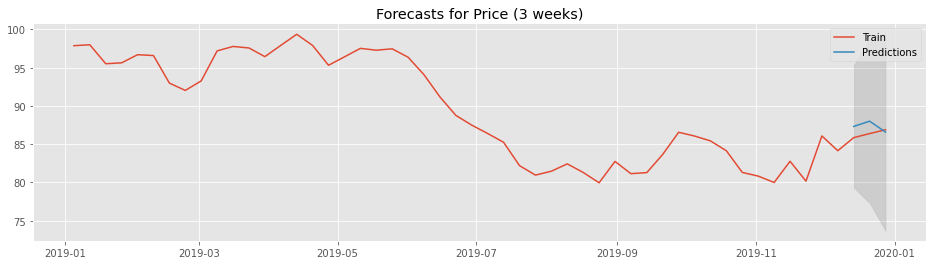

In [56]:

fig, ax = plt.subplots(1, figsize=(16, 4))

ax.plot(price_series.index[-52:], price_series[-52:], label='Train')

results = SARIMAX_price_model.get_prediction('2019-12-14', '2019-12-28', 
                   dynamic=True, ax=ax, plot_insample=False)
predictions = results.predicted_mean
ci = results.conf_int()

ax.plot(predictions.index, predictions, label='Predictions')
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='k', alpha=0.1)
ax.legend(loc='best')
ax.set_title("Forecasts for Price (3 weeks)");

In [ ]:
#print(f'MAPE for 8 weeks prediction = {mape(price_series[-8:], predictions)}') 5.283649980995582
#print(f'MAPE for 4 weeks prediction = {mape(price_series[-4:], predictions)}') 1.8025087689068624
print(f'MAPE for 3 weeks prediction = {mape(price_series[-3:], predictions)}') #1.406900113236694
#print(f'MAPE for 2 weeks prediction = {mape(price_series[-2:], predictions)}') 2.1213764454657573
#print(f'MAPE for 1 week prediction = {mape(price_series[-1:], predictions)}')  2.871966068801266

### Results for various SARIMAX models
#### SARIMAX(0,1,1)(2,1,0)[52] with test data       best AIC > 2000 
        MAPE for 42 weeks prediction = 9.996468813897012
#### SARIMAX(0,1,1)(2,1,0)[52] with all data         best AIC > 1800
#### SARIMAX(2,1,2)(2,1,0)[104] w/ all data.         best AIC = 1662.785 
        MAPE for 8 weeks prediction = 5.283649980995582
        MAPE for 4 weeks prediction = 1.8025087689068624
    ____MAPE for 3 weeks prediction = 1.406900113236694____
        MAPE for 2 weeks prediction = 2.1213764454657573
        MAPE for 1 week prediction  = 2.871966068801266
#### SARIMAX(1,1,0)(0,1,0)[156] w/ all data.         best AIC = 1446.217
        MAPE for 3 weeks prediction = 6.438030862125399

### Let's get some predictions for 2020 (pre-COVID)

In [ ]:
# # Pandas is a bit fussy about reindexing here, we need to extend the dates but
# # Pandas's weekly series does not align with google's.
# price_series.index = pd.date_range(start='2020-01-, end='9-25-2016', freq='W')
# price_series = price_series.reindex(pd.date_range(start='10-7-2011', end='2020', freq='W'))

### Predict 3 weeks in Jan 2020

In [64]:
# Actuals for 2020 (pre-COVID end february)
price_series_2020_pc = df_CHN_CTC_leaf_2020['ctc_leaf_avg_price'].iloc[:3]
price_series_2020_pc.index = pd.date_range(start='2020-01-04', end='2020-01-18', freq='W-SAT')
price_series_2020_pc

2020-01-04    87.80
2020-01-11    87.36
2020-01-18    87.68
Freq: W-SAT, Name: ctc_leaf_avg_price, dtype: float64

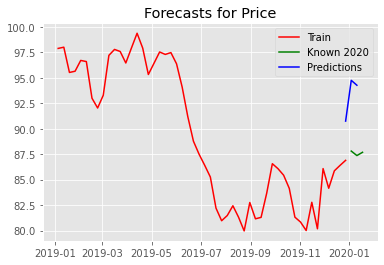

In [65]:
#fig, ax = plt.subplots(1, figsize=(16, 4))

predictions_index = pd.date_range(start='2019-12-28', end='2020-01-12', freq='W-SAT')
predictions = SARIMAX_price_model.forecast(steps=3)
predictions.index = predictions_index
predictions

plt.plot(price_series.index[-52:], price_series[-52:], label='Train', c='r')
plt.plot(price_series_2020_pc.index[:3], price_series_2020_pc[:3], label='Known 2020', c='g')
plt.plot(predictions.index, predictions, label='Predictions', c='b')

plt.title("Forecasts for Price")
plt.legend(loc='best')
plt.show();

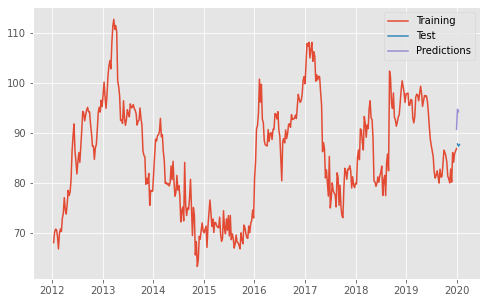

In [66]:
plt.figure(figsize=(8,5))
plt.plot(price_series, label='Training')
plt.plot(price_series_2020_pc, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend(loc='Left corner')
plt.show()

In [67]:
print(f'MAPE for 3 weeks prediction = {mape(price_series_2020_pc[:3], predictions[:3])}')

MAPE for 3 weeks prediction = 6.438030862125399


### Now let's try statsmodels.tsa.holtwinters.ExponentialSmoothing

In [85]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as Holt

HWES_price_model = Holt(np.asarray(price_series), seasonal_periods=52)
HWES_price_model._index = pd.to_datetime(price_series.index)

fit1 = HWES_price_model.fit(smoothing_level=.3, smoothing_slope=.05)
#pred1 = fit1.forecast(steps=3)
# fit2 = HWES_price_model.fit(optimized=True)
# pred2 = fit2.forecast(9)
# fit3 = HWES_price_model.fit(smoothing_level=.3, smoothing_slope=.2)
# pred3 = fit3.forecast(3)

# fig, ax = plt.subplots(figsize=(12, 6))
# ax.plot(price_series.index[52:], price_series.values[52:])
# ax.plot(test.index, test.values, color="gray")
# for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
#     ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
#     ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
# plt.title("Holt's Exponential Smoothing")
# plt.legend();

In [78]:
fit1.forecast?

In [77]:
fit1?

### Now let's try LSTM